Learning Objectives
- Describe the impacts of cloud cover on analysis of remote sensing data.
- Use a mask to remove portions of an spectral dataset (image) that is covered by clouds / shadows.
- Define mask / describe how a mask can be useful when working with remote sensing data.

### Work with Clouds, Shadows and Bad Pixels in Remote Sensing Data

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import seaborn as sns
import numpy as np
from numpy import ma
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

## Functions To Process Landsat Data
To begin, you can use the functions created in the previous lesson to process your Landsat data.

In [3]:
def check_crs(raster_path):
    """
    Returns the CRS of a raster file.

    Parameters
    ----------
    raster_path : string
        A path to a raster file that you wish to check the crs of. Assuming
        this is a tif file.

    Returns
    -------
    A crs object

    """

    with rio.open(all_landsat_post_bands[0]) as src:
        return src.crs


def open_clean_band(band_path, crop_layer=None, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band


def process_bands(paths, crop_layer=None, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).

    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.

    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

Next, you will load and plot landsat data. 

HINT: Since we are only using the RGB and the NIR bands for this exercise, you can use *band[2-5]*.tif inside glob to filter just the needed bands. This will save a lot of time in processing since you will only be using the data you need.

Note that one thing was added to the functions below - a conditional that allows you to chose to either crop or not crop your data. 

In [6]:
landsat_dirpath_pre = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "*band[2-5]*.tif")

landsat_paths_pre = sorted(glob(landsat_dirpath_pre))

landsat_pre = process_bands(landsat_paths_pre, stack=True)
landsat_pre

I'm stacking your data now.


<xarray.DataArray (band: 4, y: 177, x: 246)>
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]],

       [[2080., 1942., 1950., ..., 1748., 1802., 2135.],
        [2300., 2045., 1939., ..., 1716., 1783., 2131.],
        [2582., 2443., 2347., ..., 1836., 2002., 2241.],
        ...,
        [2076., 1993., 2145., ..., 1914., 2066., 2166.],
        [1910., 1899., 1962., ..., 1787., 2038., 2300.],
        [1633., 1611., 1738., ..., 1714., 1848., 2194.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

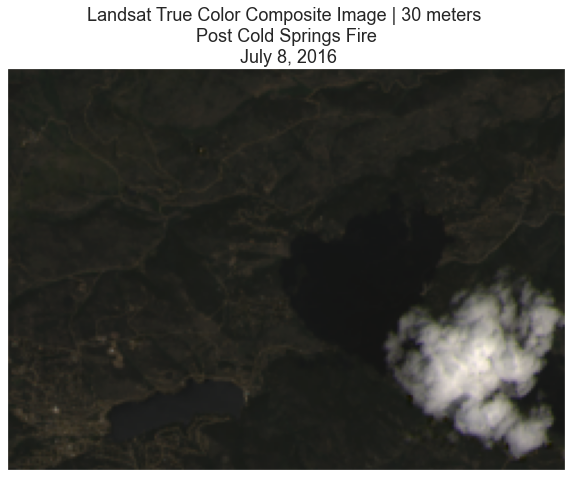

In [8]:
# Plot the data
ep.plot_rgb(landsat_pre.values,
            rgb=[2, 1, 0], # RGB real
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")

plt.show()

 You can remove cloudy pixels using a mask. Masking “bad” pixels:

- 1.Allows you to remove them from any quantitative analysis that you may perform such as calculating NDVI.
- 2.Allows you to replace them (if you want) with better pixels from another scene. This replacement if often performed when performing time series analysis of data. The following lesson will teach you have to replace pixels in a scene.